# 演習問題回答(CIFAR-10)

# モジュールのインポート

In [1]:
#モジュールのインポート
import torch
from torch import nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

#GPUチェック
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #デバイスとしてGPU(cuda)かCPUか判定
print("デバイスの種類：",device)

デバイスの種類： cuda


# ハイパーパラメータの定義

In [2]:
NUM_EPOCHS = 20 #学習時のエポック数
BATCH_SIZE = 16 #バッチサイズ
LEARNING_RATE = 0.001 #学習率
classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck') #CIFAR-10で用いられるラベル

# データセットの取得
授業テキストの方でも説明したが、データロード時にtransformをいじることで学習性能の向上を図ることができる。transformで使用できる関数（一部）を再掲する。<br>

|  関数  |  処理内容  |
| ---- | ---- |
|  Resize |  画像サイズを変形  |
|  RandomAffine  |  画像の回転および拡大縮小  |
|  RandomResizedCrop  |  ランダムに切り抜き&リサイズ  |
|  RandomHorizontalFlip  |  画像の左右反転  |
|  RandomErasing  |  画像のランダムな一部分にノイズを付加  |
|  RandomPerspective  |  画像を確率pでランダムに視覚を変換  |
|  ToTensor  |  画像データをテンソルに変換  |
|  Normalize  |  画像データを標準化  |

<br>

今回はこの中から画像の水増し、画像の標準化を行う。

In [3]:
#transformの方法を定義。今回はTensorへの変形だけではなく、回転、拡大縮小により画像データを水増し。画像の標準化も行っている。
transform = transforms.Compose([
    transforms.RandomAffine([0,30], scale=(0.8, 1.2)), #回転および拡大縮小
    transforms.RandomHorizontalFlip(p=0.5), #左右反転
    transforms.ToTensor(), #画像データをTensorに変形
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #標準化。(平均、標準偏差)、[0, 1] => [-1, 1]
])

train_datasets = datasets.CIFAR10(root="cifar10data",
                                  train = True,
                                  download = True,
                                  transform=transform)
test_datasets =datasets.CIFAR10(root="cifar10data",
                          train=False,
                          download=True,
                          transform=transform)

#データローダーの作成
train_loader = DataLoader(train_datasets,
                           batch_size=BATCH_SIZE, 
                           shuffle=False)
test_loader = DataLoader(test_datasets,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10data/cifar-10-python.tar.gz to cifar10data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

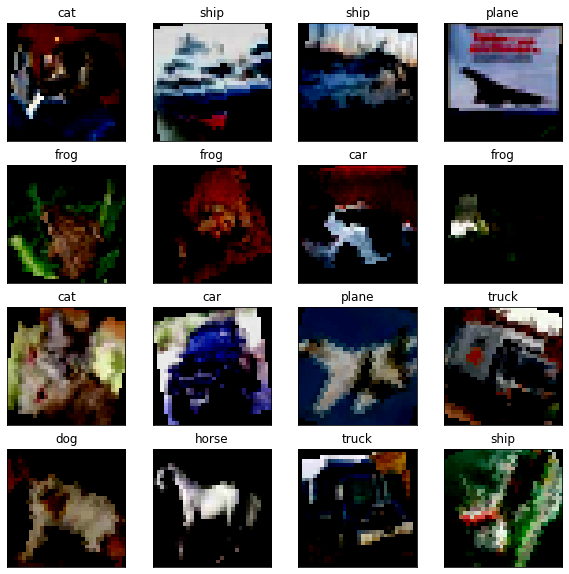

In [4]:
#図の描画
plt.figure(figsize=(10,10)) #画像の表示サイズ
chkdata = iter(test_loader)
chkimages, chklabels = chkdata.next() #イテレータから最初のバッチを取り出す
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(np.transpose(chkimages[i], (1, 2, 0)))
    label = classes[chklabels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False) #ラベルとメモリを非表示に
plt.show()

このように、ToTensor()だけの場合と比較して画像の回転や色彩の変化がみて取れるだろう。

# 学習モデルの作成

入力画像が(32,32)、カーネルサイズ5×5、ストライド1、パディング0とすると、画像サイズの変化は以下のようになる。
- 畳み込み層1
\begin{equation}
{\frac{32+2\cdot{0}-5}{1}+1=28}
\end{equation}
- プーリング層1
\begin{equation}
{\frac{28}{2}=14}
\end{equation}
- 畳み込み層2
\begin{equation}
{\frac{14+2\cdot{0}-5}{1}+1=10}
\end{equation}
- プーリング層2
\begin{equation}
{\frac{10}{2}=5}
\end{equation}
- 全結合層
\begin{equation}
{5\cdot{5}\cdot{20}}
\end{equation}

In [5]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3,10,kernel_size=5),
        nn.BatchNorm2d(10),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(10,20,kernel_size=5),
        nn.BatchNorm2d(20),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc = nn.Sequential(
        nn.Linear(5*5*20,256),
        nn.Linear(256,128),
        nn.Linear(128,10))
  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = out.view(out.size(0), -1) #テンソルの形を変換
      out = self.fc(out)
      return out

model = CNN().to(device) #GPUに送る
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=500, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

# 最適化アルゴリズム、損失関数設定
- 損失関数として交差エントロピー誤差
- 最適化アルゴリズムとしてadam

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 学習実行

In [7]:
def train(train_loader):
    model.train()
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader): 
        images = images.to(device) #GPUにいれる
        labels = labels.to(device) #GPUにいれる
        optimizer.zero_grad() #テンソル勾配のクリア
        outputs = model(images) #CNNモデルを用いて計算
        loss = criterion(outputs, labels) #ロス計算
        running_loss += loss.item()
        loss.backward() #誤差逆伝播
        optimizer.step() #パラメータ更新
    train_loss = running_loss / len(train_loader)
    return train_loss

def valid(test_loader):
    model.eval() 
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): #optimizer.zero_grad()を呼び出す必要がなくなる、optimizer.zero_grad()がいらなくなる
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) #ロスの計算
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.view_as(predicted)).sum().item() #精度の計算
            total += labels.size(0)
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(NUM_EPOCHS):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)
    print('Epoch %d, Loss: %.4f Val_loss: %.4f Val_acc: %.4f' % (epoch, loss, val_loss, val_acc))

    #損失、精度をリストに格納
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
print('訓練終了')

#結果の保存とモデルの保存
np.save('loss_list.npy', np.array(loss_list))
np.save('val_loss_list.npy', np.array(val_loss_list))
np.save('val_acc_list.npy', np.array(val_acc_list))
torch.save(model.state_dict(), 'cnn.pkl')

Epoch 0, Loss: 1.6068 Val_loss: 1.4612 Val_acc: 0.4640
Epoch 1, Loss: 1.4290 Val_loss: 1.3983 Val_acc: 0.4969
Epoch 2, Loss: 1.3610 Val_loss: 1.3223 Val_acc: 0.5252
Epoch 3, Loss: 1.3234 Val_loss: 1.3159 Val_acc: 0.5306
Epoch 4, Loss: 1.2958 Val_loss: 1.2664 Val_acc: 0.5495
Epoch 5, Loss: 1.2723 Val_loss: 1.2257 Val_acc: 0.5668
Epoch 6, Loss: 1.2595 Val_loss: 1.2364 Val_acc: 0.5609
Epoch 7, Loss: 1.2456 Val_loss: 1.1924 Val_acc: 0.5747
Epoch 8, Loss: 1.2348 Val_loss: 1.1885 Val_acc: 0.5818
Epoch 9, Loss: 1.2268 Val_loss: 1.2003 Val_acc: 0.5744
Epoch 10, Loss: 1.2123 Val_loss: 1.1575 Val_acc: 0.5948
Epoch 11, Loss: 1.2095 Val_loss: 1.1742 Val_acc: 0.5819
Epoch 12, Loss: 1.2008 Val_loss: 1.1477 Val_acc: 0.5954
Epoch 13, Loss: 1.1957 Val_loss: 1.1531 Val_acc: 0.5929
Epoch 14, Loss: 1.1895 Val_loss: 1.1562 Val_acc: 0.5955
Epoch 15, Loss: 1.1877 Val_loss: 1.1443 Val_acc: 0.5955
Epoch 16, Loss: 1.1779 Val_loss: 1.1390 Val_acc: 0.5929
Epoch 17, Loss: 1.1765 Val_loss: 1.1539 Val_acc: 0.5867
Ep

# 結果表示

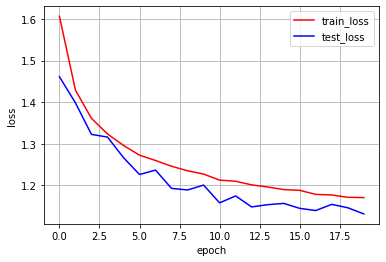

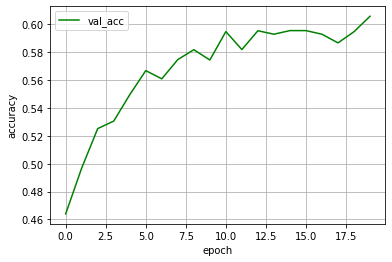

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(NUM_EPOCHS), loss_list, 'r-', label='train_loss')
plt.plot(range(NUM_EPOCHS), val_loss_list, 'b-', label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(NUM_EPOCHS), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()

転移学習の結果と比較するとこちらの結果の方が優れているが、あまり大きな差が生まれていないことが分かる。転移学習は1000枚の学習データで60%弱の精度を得たのに対し、CNNでは50000枚の学習データから60%の学習精度を実現している。このことからも転移学習の有用性が確認できる。学習データ60000枚を用いて転移学習を行った場合の精度はどの程度になるか検証してみても面白いと思う。

# 訓練済みモデルを用いた予測

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


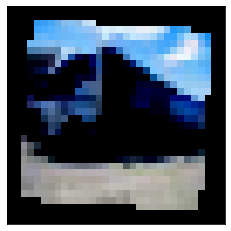

正解: truck 予測結果: truck


In [11]:
dataiter = iter(torch.utils.data.DataLoader(test_datasets, shuffle=True))
images, labels = dataiter.next() #サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0))) #チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False) #ラベルとメモリを非表示に
plt.show()

model.eval() #評価モード
imagee, labele = images.cuda(), labels.cuda() #GPU対応
with torch.no_grad():
  labely = model(imagee)
print("正解:", classes[labels[0]],"予測結果:", classes[labely.argmax().item()])

このように、MNISTの場合と比較すると学習精度が低いことが確認できる。ここから、どのようなテクニックを用いれば学習精度を高めることができるか是非検討を行ってみてほしい。